In [1]:
import numpy as np
import scipy.stats as stats
from particles.kalman import Kalman, LinearGauss
from particles.core import SMC, multiSMC, FeynmanKac
import particles.state_space_models as ssms
from sdes.auxiliary_bridges import LocalLinearOUProp 
from sdes.sdes import OrnsteinUhlenbeck, ManualOptOU
from sdes.tools import start_points_paths_to_array, struct_array_to_array, plot_simulations
from sdes.feynman_kac import BootstrapDA, ForwardGuidedDA
from sdes.path_integrals import log_girsanov
import matplotlib.pyplot as plt
import seaborn as sb
import sdeint

Consider the Ornstein-Uhlenbeck process in one-dimension:

$$dV(s) = -\rho V(s) ds + \phi dW(s) \qquad V(0) = 0.$$ (1)

This process is observed at $T$ discrete times $s_1 < s_2 < \dots < s_T$, with noise. So we are working with a continuous time set $\mathcal{S} = [0, S]$ and a discrete one $\mathcal{T} = \{1, \dots T\}$. We set $V_t = V(s_t)$

We assume for simplicity that observation times are equidistant $s_t - s_{t-1} = \Delta s = 1$, and we define each observation density $p_t(y_t|v_t)$ to be linear, Gaussian:

$$Y_t |V_t = v_t \sim \mathcal{N}(v_t, \eta^2)$$ (2)

Equation (1)-(2) defines a CD-SSM with parameters $\theta = (\rho, \phi, \eta^2)$. As the OU process is a linear SDE, it has a tractable transition density $p_t(v_t|v_{t-1})$, given by:

$$V_t|V_{t-1} = v_{t-1} \sim \mathcal{N}(e^{-\rho \Delta s}v_{t-1}, \frac{\phi^2}{2\rho}(1 - e^{-2\rho \Delta s}))$$

Thus, the random variables $(V_{1:T}, Y_{1:T})$ form a linear, Gaussian state space model, and it is possible to derive analytically the filtering and smoothing distributions, through Kalman filtering and smoothing. One can also implement particle filters/smoothers on discrete space, without data augmentation, with the optimal proposal being analytically tractable. Finally, the data augmentation approaches outlined in the contribution can be used.

We define the unknowns in this model below:

We fix parameter values $\theta = (\rho, \phi, \eta^2) = (0.4, 0.5, 0.1^2)$ this choice is used in the OU experiment in Yonekura and Beskos (2020)

We fix parameter values $\theta = (\rho, \phi, \eta^2) = (0.2, 0.3, 0.01^2)$ this is a low noise regime, where guiding the proposals is a necessary requirement.

In [2]:
Delta_s = 1.; rho = 0.4; phi = 0.5; eta = 0.1
T = 100; N = 1000 # Length of the data  #Number of particles for pfs
num = 100 # Number of imputed points for simulation of paths
ou_params = {'rho': rho, 'phi': phi}
ou_model_params = {**ou_params, 'eta': 0.01}
linear_gauss_params = {'sigmaY': eta,
                       'rho': np.exp(-rho*Delta_s),
                       'sigmaX': np.sqrt((phi ** 2)/(2*rho) * (1 - np.exp(-2*rho*Delta_s))),
                       'sigma0': np.sqrt((phi ** 2)/(2*rho) * (1 - np.exp(-2*rho*Delta_s)))
                      }

In [3]:
np.random.seed(1) # Set random seed
LGSSM = LinearGauss(**linear_gauss_params)
x, y = LGSSM.simulate(T) # Generate synthetic data

In [4]:
# Discrete Time FK
bootstrap_fk = ssms.Bootstrap(ssm=LGSSM, data=y)
guided_fk = ssms.GuidedPF(ssm=LGSSM, data=y)
auxiliary_fk = ssms.AuxiliaryPF(ssm=LGSSM, data=y)

# Continuous Time FK
bootstrap_da_fk = BootstrapDA(y, num, eta, **ou_params)
forward_proposal_fk = ForwardGuidedDA(y, num, eta, **ou_params)

#Particle Filters in Discrete Time
bootstrap_pf = SMC(fk=bootstrap_fk, N=N, store_history=True)
guided_pf = SMC(fk=guided_fk, N=N, store_history=True)
auxiliary_pf = SMC(fk=auxiliary_fk, N=N, store_history=True)

#Particle Filters in Continuous Time
bootstrap_da_pf = SMC(fk=bootstrap_da_fk, N=N, store_history=True)
forward_proposal_pf = SMC(fk=forward_proposal_fk, N=N, store_history=True)

bootstrap_pf.run() 
guided_pf.run() #Uses the optimal proposal
auxiliary_pf.run() #Uses the optimal auxiliary weight

bootstrap_da_pf.run()  # Bootstrap filter that uses simulations from the SDE
forward_proposal_pf.run() # Guided filter that uses log girsanov weights 


# Kalman Filter benchmark
kf = Kalman(ssm=LGSSM, data=y)
kf.filter()

In [5]:
t = 0
mean = kf.filt[t].mean #Extract the mean
bootstrap_pf_hist = bootstrap_pf.hist # Particle History object
X, wgts = bootstrap_pf_hist.X[t], bootstrap_pf_hist.wgts[t] 

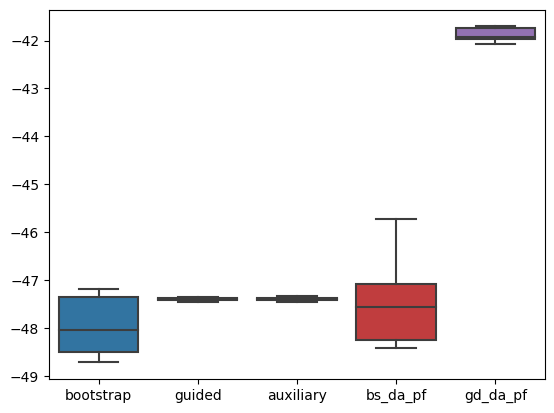

In [6]:
results = multiSMC(nruns=10, fk={'bootstrap': bootstrap_fk,
                                    'guided': guided_fk, 
                                   'auxiliary': auxiliary_fk,
                                   'bs_da_pf': bootstrap_da_fk, 
                                   'gd_da_pf': forward_proposal_fk
                      }, N=1000)
sb.boxplot(x=[r['fk'] for r in results], y=[r['output'].logLt for r in results]);

In [7]:
forward_proposal_pf.summaries.logLts[:10]

[-1.057071717372189]

In [8]:
true_py = np.cumsum([a[0][0] for a in kf.logpyt])
true_py[-1]

-47.36560196381598

In [9]:
true_py

array([-1.0979814])

In [10]:
bootstrap_pf.summaries.logLts[:10]

[-1.1290895509338752]

In [11]:
bootstrap_pf.logLt, guided_pf.logLt, auxiliary_pf.logLt, bootstrap_da_pf.logLt, forward_proposal_pf.logLt 

(-1.1290895509338752,
 -1.0979813995458156,
 -1.0979813995458163,
 -1.0734313459943106,
 -1.057071717372189)

In [12]:
bootstrap_pf.summaries.ESSs, guided_pf.summaries.ESSs, auxiliary_pf.summaries.ESSs, bootstrap_da_pf.summaries.ESSs, forward_proposal_pf.summaries.ESSs 

([122.17142475603055],
 [1000.0000000000007],
 [999.9999999999998],
 [122.4355528678643],
 [912.9999793632371])

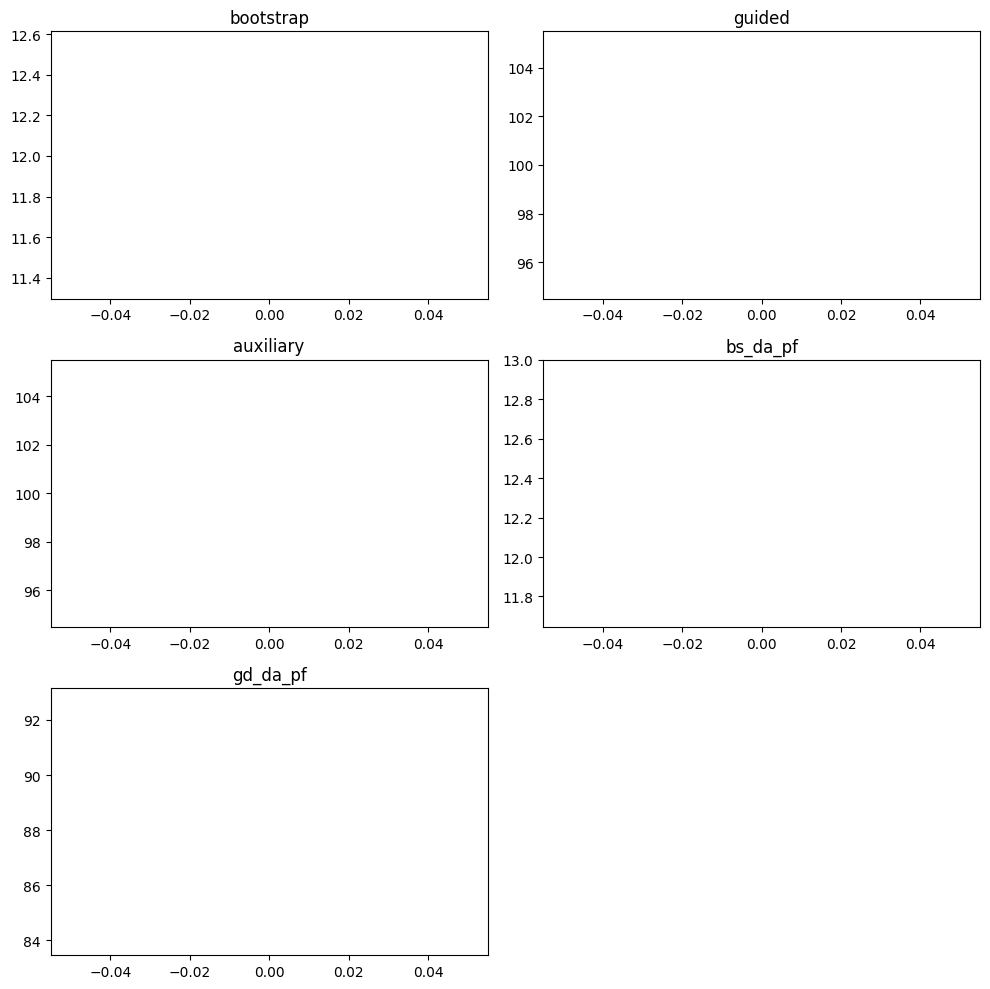

In [12]:
pfs = [bootstrap_pf, guided_pf, auxiliary_pf, bootstrap_da_pf, forward_proposal_pf]
labels = ['bootstrap', 'guided', 'auxiliary', 'bs_da_pf', 'gd_da_pf']

fig, axes = plt.subplots(3, 2, figsize=(10, 10))

axes = axes.reshape(-1,)

for i in range(5):
    ax = axes[i]
    ax.plot(pfs[i].summaries.ESSs)
    ax.set_title(labels[i])

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()